# Advanced Deep Learning (D7047E) - Lab 1

## Imports

In [2]:
%%capture

import os
import math
import nltk
import torch
import random

import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tempfile import TemporaryDirectory

from nltk import word_tokenize
from nltk.corpus import stopwords

from IPython.display import display

from torch import FloatTensor, LongTensor

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

## Task 1 - ANN for Sentiment Analysis

### Dataset Initialization

In [ ]:
dataset = pd.read_csv(
    "amazon_cells_labelled.txt",
    names=['Sentence', 'Class'],
    delimiter='\t'
)

### Preprocessing

#### Format Reviews

In [ ]:
# Lowercase
dataset['Sentence'] = dataset['Sentence'].str.lower()

# Remove stopwords
dataset['Sentence'] = dataset['Sentence'].apply(
    lambda row: " ".join([
        w
        for w in word_tokenize(row)
        if w not in stopwords.words('english')
    ])
)

# Remove everything that is not a letter or whitespace
dataset['Sentence'] = dataset['Sentence'].replace('[^a-z ]+', ' ', regex=True)

# Remove multiple whitespaces
dataset['Sentence'] = dataset['Sentence'].replace(' +', ' ', regex=True)

# Strip whitespace
dataset['Sentence'] = dataset['Sentence'].str.strip()

#### Split into Training & Validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    dataset['Sentence'].values.astype('U'),
    dataset['Class'].values.astype('int32'),
    train_size=0.9,
    random_state=45,
    shuffle=True
)

#### Vectorize

In [ ]:
word_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,2),
    max_features=50000,
    max_df=0.5,
    use_idf=True,
    norm='l2'
)

# Transforms texts into matrices
X_train_vectorized = word_vectorizer.fit_transform(X_train).todense()
X_val_vectorized = word_vectorizer.transform(X_val).todense()

#### Convert to Tensors

In [ ]:
X_train_tensor = FloatTensor(X_train_vectorized)
X_val_tensor = FloatTensor(X_val_vectorized)

y_train_tensor = LongTensor(y_train)
y_val_tensor = LongTensor(y_val)

### Network Initialization

In [ ]:
NUM_EPOCHS = 100

# Sizes
input_size = len(word_vectorizer.vocabulary_)
output_size = 2

# Model
model = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, output_size)
)

# Optimizer
optimizer = optim.Adam(model.parameters())

# Loss Function
criterion = nn.CrossEntropyLoss()

### Training

#### Implementation

In [ ]:
losses = []
model.train()

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()

    y_pred = model(X_train_tensor)

    loss = criterion(y_pred, y_train_tensor)
    loss.backward()

    optimizer.step()

    losses.append(loss.item())

#### Plotting Loss Per Epoch

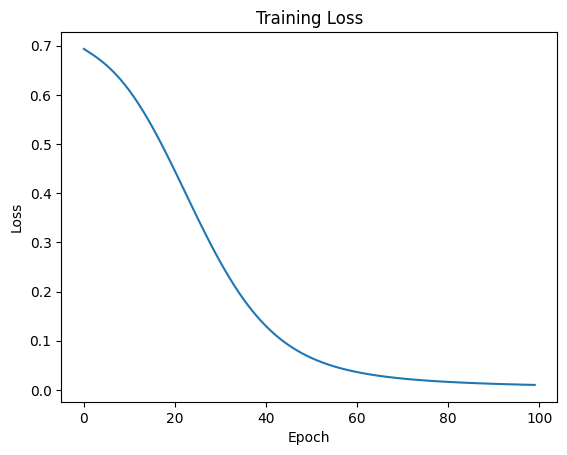

In [ ]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training Loss')

plt.show()

### Validation

In [ ]:
model.eval()

with torch.no_grad():
    y_pred = model(X_val_tensor)

guess = torch.argmax(y_pred, axis=1)
no_correct_guesses = (guess == y_val_tensor).sum().item()
accuracy = no_correct_guesses * 100 / y_val_tensor.shape[0]

print(f"Validation Accuracy: {round(accuracy, 2)}%")

Validation Accuracy: 82.0%


### Testing the Chatbot

#### Possible Responses

In [ ]:
positive_responses = [
    "That's great to hear!",
    "I'm glad you feel that way!"
]

negative_responses = [
    "I'm sorry to hear that.",
    "I'm sorry you're upset, let’s try to make things right."
]

def get_response(user_input):
    intent = get_intent(user_input)
    responses_chosen = positive_responses if intent == 1 else negative_responses

    return random.choice(responses_chosen)

def get_intent(user_input):
    text_vectorized = word_vectorizer.transform([user_input]).todense()
    text_tensor = FloatTensor(text_vectorized)

    with torch.no_grad():
        output = model(text_tensor)
        guess = torch.argmax(output, dim=1).item()

    return guess

#### Prompt the User

In [ ]:
chat_output = widgets.Output()
text_input = widgets.Text(placeholder="Type here...")
submit_button = widgets.Button(description="Submit")

with chat_output:
    print("> How are you feeling?")

def on_submit(b):
    user_input = text_input.value
    text_input.value = ""

    if user_input.strip():
        with chat_output:
            print(f"{user_input}")
            print(">" + get_response(user_input))

submit_button.on_click(on_submit)
text_input.on_submit(on_submit)

input_box = widgets.HBox([text_input, submit_button])
display(chat_output, input_box)

Output()

## Task 2 - Next Word Prediction with Transformer

### Helpers

#### GPU Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Positional Encoding

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[0]]

        return self.dropout(x)

#### Model Class

In [5]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, d_hid, nlayers, dropout = 0.5):
        super().__init__()

        self.model_type = 'Transformer'
        self.d_model = d_model

        self.pos_encoder = PositionalEncoding(d_model, dropout)

        encoder_layers = nn.TransformerEncoderLayer(
            d_model,
            nhead,
            d_hid,
            dropout,
            device=device
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            nlayers,
            enable_nested_tensor=False
        )

        self.linear = nn.Linear(d_model, ntoken)
        self.embedding = nn.Embedding(ntoken, d_model)

        # Weights
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)

        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask = None):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        if src_mask is None:
            """
                Generate a square causal mask for the sequence.
                The masked positions are filled with float('-inf').
                Unmasked positions are filled with float(0.0).
            """

            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src))
            src_mask.to(device)

        output = self.transformer_encoder(src, src_mask)

        return self.linear(output)

#### Processing and Batching

In [6]:
bptt = 35
tokenizer = get_tokenizer('basic_english')

def data_process(raw_text_iter, vocab):
    """Converts raw text into a flat Tensor."""

    data = [
        torch.tensor(vocab(tokenizer(item)), dtype=torch.long)
        for item in raw_text_iter
    ]

    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

def batchify(data, bsz):
    """
        Divides the data into ``bsz`` separate sequencesremoving extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """

    seq_len = data.shape[0] // bsz

    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()

    return data.to(device)

def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)

    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)

    return data, target

### Dataset Initialization

In [7]:
batch_size = 20
eval_batch_size = 10

with open("wiki.train.txt") as f:
    train_data = f.read()

with open("wiki.valid.txt") as f:
    valid_data = f.read()

with open("wiki.test.txt") as f:
    test_data = f.read()

vocab = build_vocab_from_iterator(
    map(tokenizer, train_data),
    specials=['<unk>']
)

vocab.set_default_index(vocab['<unk>'])

X_train = data_process(train_data, vocab)
X_val = data_process(valid_data, vocab)
X_test = data_process(test_data, vocab)

# X shape: ``[seq_len, batch_size]``
X_train = batchify(X_train, batch_size)
X_val = batchify(X_val, eval_batch_size)
X_test = batchify(X_test, eval_batch_size)

### Network Initialization

In [8]:
# Size of Vocabulary
ntokens = len(vocab)

# Embedding Dimension
emsize = 200

# Dimension for FFNN in TransformerDecoder
d_hid = 200

# Number of Layers in TransformerEncoder
nlayers = 2

# Number of heads in Multi-Head Attention
nhead = 2

# Dropout Rate
dropout = 0.2

# Model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

### Training & Validation

#### Implementation

In [9]:
NUM_EPOCHS = 10
best_validation_loss = float('inf')
train_losses, validation_losses = [], []

with TemporaryDirectory() as temp_dir:
    best_model_params_path = os.path.join(temp_dir, "best_model_params.pt")

    for epoch in range(NUM_EPOCHS):
        train_loss = val_loss = 0
        model.train()

        for i in range(0, X_train.shape[0] - 1, bptt):
            optimizer.zero_grad()

            data, targets = get_batch(X_train, i)
            output = model(data).view(-1, ntokens)

            loss = criterion(output, targets)
            loss.backward()

            train_loss += data.shape[0] * loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

            optimizer.step()

        scheduler.step()

        model.eval()

        with torch.no_grad():
            for i in range(0, X_val.shape[0] - 1, bptt):
                data, targets = get_batch(X_val, i)
                output = model(data).view(-1, ntokens)

                loss = criterion(output, targets).item()
                val_loss += data.shape[0] * loss

        train_loss_per_epoch = train_loss / (X_train.shape[0] - 1)
        val_loss_per_epoch = val_loss / (X_val.shape[0] - 1)

        train_losses.append(train_loss_per_epoch)
        validation_losses.append(val_loss_per_epoch)

        if val_loss_per_epoch < best_validation_loss:
            best_validation_loss = val_loss_per_epoch

            # Save best model
            torch.save(model.state_dict(), best_model_params_path)

    # Load best model
    model.load_state_dict(torch.load(best_model_params_path))

#### Plotting Losses Per Epoch

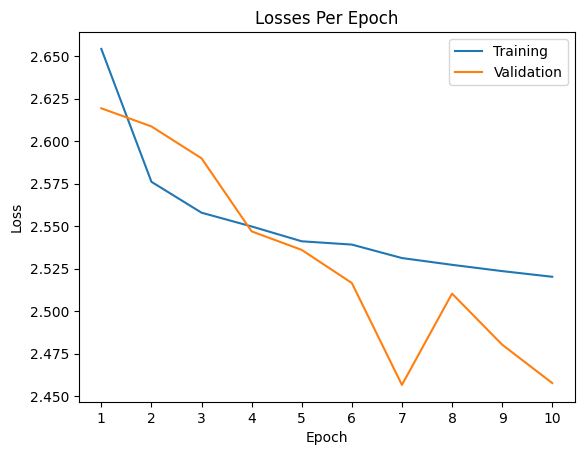

In [10]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Losses Per Epoch')
plt.legend()

plt.xticks(ticks=range(NUM_EPOCHS), labels=range(1, NUM_EPOCHS + 1))

plt.show()

### Testing

In [25]:
no_correct_guesses = no_total_guesses = 0
model.eval()

with torch.no_grad():
    for i in range(0, X_test.shape[0] - 1, bptt):
        data, targets = get_batch(X_test, i)
        output = model(data).view(-1, ntokens)

        guesses = torch.argmax(output, axis = 1)
        no_correct_guesses += (guesses == targets).sum().item()
        no_total_guesses += targets.shape[0]

accuracy = round((no_correct_guesses * 100) / no_total_guesses, 2)
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 28.71%


## Task 3 - Comparing the two methods

The performance for the ANN is much higher (82%) compared to the Transformer (28%).

This is due to the following:
- large amount of time needed to train the Transformer properly
- complexity of the Transformer network
- complexity of the task (the ANN tries to classify sentences into positive/negative while the Transformer tries to generate sequences)